Number of cells: 1009
Reattached? 1
Self-regulating? 1


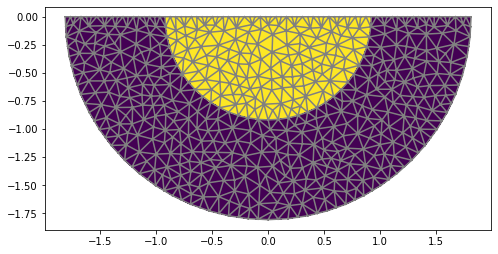

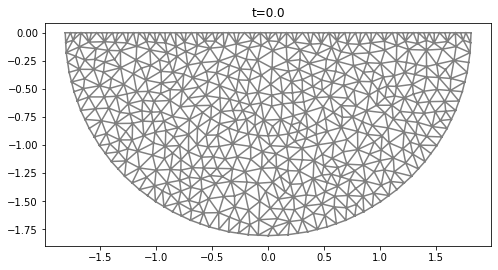

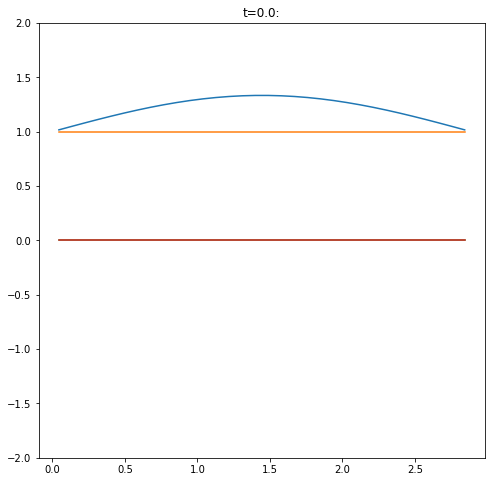

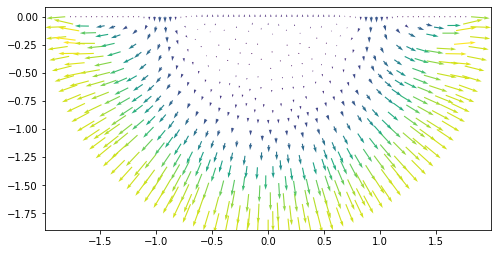

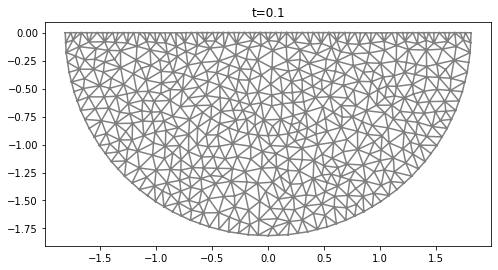

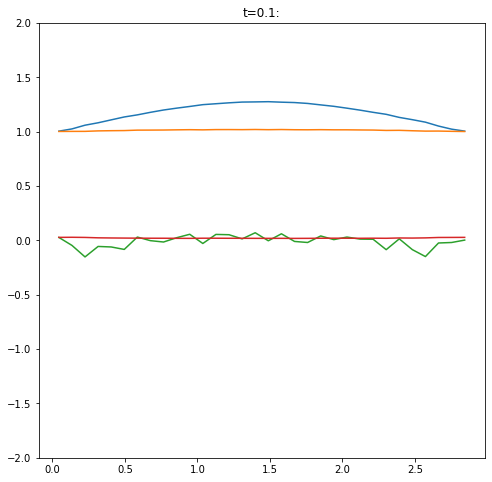

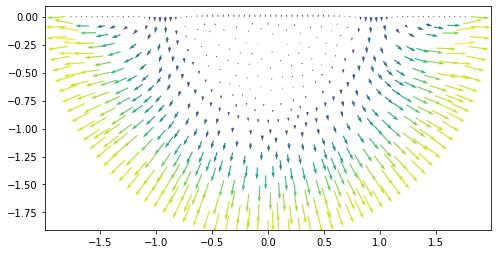

KeyboardInterrupt: 

In [2]:
from dolfin import *
from mshr import *
import matplotlib.pyplot as plt
import numpy as np
import os
import shapely.geometry as geom
import shutil
from scipy.interpolate import interp1d

#To avoid issues during remeshing
parameters['allow_extrapolation'] = True

'''Scalings'''
# Length scale: mm
# Time scale: hours
# The numerical code is entirely dimensional.

'''Parameters'''

# Length scales (all in mm)
Er = 1.81  # embryo radius
r = .92 # margin radius
d = .12 # margin thickness
offset = .106 #initial downward displacement of EP in mm
l_diff = .1583 # diffusion length

# Time scales
tau = 0.5 # myosin regulation time scale [hrs]
emax = 1/3 # maximal contraction rate [1/hrs]
ve_time = 0.5 # margin viscoelastic time scale [hrs]

# Myosin scale
c0 = 1 #set to 1 (unknown units).

# Tension scale
Ts = 1 #set to 1 (unknown number of Newtons per unit myosin)

# Dimensionless biological parameters (controlling myosin regulation in response to stretching)
alpha = -1.0 # regulation offset
beta = 16.0 # sensitivity of myosin to stretching
zeta = 1/3 # amplitude of myosin variation
lam  = 4.0 # #sensitivity of walkers to tension

# Tissue viscosity scale
mu = 0.1 # 2D tissue viscosity ( in units of [c0*Ts] * hours / mm )

# Edge Friction
fr = 100 #Friction of cut boundary in case of reattachment, choose large

####

# Margin visco-elasticity (emerging from walking kernel model, for information only)
E = 1/(lam*emax*ve_time) # = 1.5, margin elasticity ( in units of [c0*Ts] )
nu = 1/(lam*emax) # = 0.75, 1D margin viscosity ( in units of [c0*Ts] * hours )

# Dimensionless quantities are only calculated for theoretical interpretation, not used in calculation


'''Initial conditions and numerical settings'''

# Initialisation parameters
Camp = c0*zeta #initial myosin amplitude (perturbation from equilibrium)
initialT = c0*Ts #c0*Ts #initial tension (uniform along margin)

# Regulation settings
dt = 0.05 #time step for FEM and mesh advection
subd = 10 #factor finer time step for margin timestepping
nrep = 161 #number of FEM time steps
remeshinterval = 10 #remesh after this many FEM timesteps

# general parameters
t = 0 #start time
N = 32 #number of margin segments, choose even
dataDir='output' # output data directory

# numerical parameters
meshres = .2 #mesh resolution in mm
pen = 2000 #penalty for weak enforcement of no slip boundary condition if divergence is non-zero, choose large
THorder = 2 #order of the FE method (choose at least 1. Velocity elements have degree THorder + 1)
tol = 1E-10 #numerical tolerance (coefficient of pressure penalty stabilising term)
figureSize = 8 #figure Size
Lambda = Constant(2000) #penalty for weak enforcement of no slip boundary condition if divergence is non-zero, choose large

# switches
reattach = 1 #Set to 0 if not reattached, 1 if reattached boundary
antpost = 1 # 0 for anterior, 1 for posterior
regulate = 1 # if 0 tension has fixed gaussian profile WARNING regulate=0 has not yet been tested
remesh = 1 #remesh WARNING REMESHING RESETS THE LOCUS OF THE HAIR (IF PRESENT)
echo = 0 #output values of margin quantities
output = 1 #flag for saving output. 1 = on, 0 = off
epibolyflag = 1 # activate epiboly


######################

'''Save parameters'''

if output:
    #copy code to data folder 
    if os.path.exists(dataDir):
        os.system('rm '+dataDir+'/*')
    else:
        os.makedirs(dataDir)
    os.system('jupyter nbconvert --to script Cut.ipynb')
    os.system('mv Cut.py '+dataDir)

if output:
    #prepare export
    file1 = File(dataDir+'/u.pvd')   
    file2 = File(dataDir+'/p.pvd')
    file3 = File(dataDir+'/mesh.pvd')
    fT=open(dataDir+'/T.txt','wb')
    fgd=open(dataDir+'/gd.txt','wb')
    fc=open(dataDir+'/c.txt','wb')
    fl=open(dataDir+'/l.txt','wb')
    fps=open(dataDir+'/ps.txt','wb')
    fmvel=open(dataDir+'/margvel.txt','wb')
    ft=open(dataDir+'/time.txt','wt')

'''Initialisation of margin'''

#Create margin segments
if antpost:
    angles =  np.pi / (N+2*tol) * (np.arange(N+1)+tol) -np.pi # N+1 points with N segments between them
else:
    angles =  np.pi / (N+2*tol) * (np.arange(N+1)+tol) # N+1 points with N segments between them
ps = np.array([r*np.cos(angles),r*np.sin(angles)]).T #define array of initial positions

# Margin velocity
margvel=np.zeros(N)

# Extension rate
gd = np.zeros(N)

# segment lengths l, cumulative lengths cumt, tangent vectors ta, and tangent angles th
def updatelengths(ps):
    l = np.zeros(N)
    cumt = np.zeros(N) #cum length of segments measured from midpoint of segments
    ta = np.zeros((N,2)) #tangent vectors
    th = np.zeros(N) #tangent angles
    margin = geom.LineString(ps) #define linear string geometric object from array
    lvec = np.roll(ps,-2)-ps
    for i in range(N):
        l[i] = np.linalg.norm(lvec[i,:])
    lt = (l + np.roll(l,-1))/2
    for i in range(N):
        if i==0:
            cumt[i] = l[0]/2
        else:
            cumt[i] = cumt[i-1]+lt[i-1]
        ta[i,:] = lvec[i,:]/l[i]
        th[i] = np.arctan2(ta[i,1],ta[i,0])
        if i > 0 and th[i] < th[i-1] - np.pi: #arbitrary threshold, may cause bug
            th[i] += 2*np.pi
    return margin, l, lt, cumt, th, ta

margin, l, lt, cumt, th, ta = updatelengths(ps)

# peak tension
def maxTension(t):
    return 2.7*mu*(1+np.tanh(2*(t-.95)/2.9))/2*np.exp(-t/8.3) #time in Francis' units
    
# Gaussian tension profile
def tensions(ps,t):
    c = geom.Polygon(ps).centroid # margin center
    mp = (np.roll(ps,-2)+ps)/2 # midpoints
    T = np.zeros(N)
    for i in range(N):
        a = np.arctan2(mp[i,0]-c.x,c.y-mp[i,1])
        T[i] = np.exp(-np.square(a/.698)/2)
    return maxTension(t)*T

# Scalar Tension
if regulate:
    T = initialT * np.ones(N)
else:
    T = tensions(ps,t)
dT = np.zeros(N)

#Define initial myosin profile
c = c0+Camp*np.cos(th)
dc = np.zeros(N)

cinterp = interp1d(cumt,c,kind='linear',fill_value="extrapolate",bounds_error=False) # Myosin interpolator
Tinterp = interp1d(cumt,T,kind='linear',fill_value="extrapolate",bounds_error=False) # Tension interpolator
thinterp = interp1d(cumt,th,kind='linear',fill_value="extrapolate",bounds_error=False) # tangent angle interpolator
#Note: All of these extrapolate linearly between the midpoint of the first/last margin segment and the cut. The error of this approximation is small for a large number of margin segments


'''Meshing'''

# Define geometry of embryonic disk
currentradius = Er

#Define arrays of boundary segments
outercontour=ps*currentradius/r;
cutcontour1= np.column_stack((np.linspace(outercontour[-1,0],ps[-1,0],num=20),
         np.linspace(outercontour[-1,1],ps[-1,1],num=20)))
cutcontour2=np.column_stack((np.linspace(ps[-1,0],ps[0,0],num=40),
         np.linspace(ps[-1,1],ps[0,1],num=40)))
cutcontour3= np.column_stack((np.linspace(ps[0,0],outercontour[0,0],num=20),
         np.linspace(ps[0,1],outercontour[0,1],num=20)))

# Define contourlengths
outercontourlength=np.shape(outercontour)[0]
cutcontour1length=np.shape(cutcontour1)[0]
cutcontour2length=np.shape(cutcontour2)[0]
cutcontour3length=np.shape(cutcontour3)[0]

#Concatenate segments
embryocircumf=np.vstack((outercontour,cutcontour1,cutcontour2,cutcontour3))
margincircumf=np.vstack((ps,cutcontour2))

#Define shapely object of the cut and the outer boundary
cutshape = geom.LineString(np.vstack((cutcontour1,cutcontour2,cutcontour3)))
outershape = geom.LineString(outercontour)

# Define margin as mesh contour
meshmarginpoints = [0]*np.shape(margincircumf)[0]
for i in range(np.shape(margincircumf)[0]):
    meshmarginpoints[i] = Point(margincircumf[i,0],margincircumf[i,1])
marginmesh = Polygon(meshmarginpoints)

# Define embryonic disk circumference
embryomeshpoints = [0]*np.shape(embryocircumf)[0]
for i in range(np.shape(embryocircumf)[0]):
    embryomeshpoints[i] = Point(embryocircumf[i,0],embryocircumf[i,1])
embryomesh = Polygon(embryomeshpoints)

# Label subdomains for later reference (unmarked = index 0)
embryomesh.set_subdomain(1, marginmesh) #EP is subdomain index 1

# generate mesh
mesh = generate_mesh(embryomesh, 2*currentradius/meshres)

# generate markers for domains
markers = MeshFunction('size_t', mesh, 2, mesh.domains()) #Label subdomains with integers

#Define section of boundary on which epiboly acts and cut (refer to tutorial ft10)
class Boundary_outer(SubDomain):
        def inside(self, x, on_boundary):
            return on_boundary and outershape.distance(geom.Point(x[0],x[1])) < tol 
class Boundary_cut(SubDomain):
        def inside(self, x, on_boundary):
            return on_boundary and cutshape.distance(geom.Point(x[0],x[1])) < tol 
        
boundary_markers = MeshFunction('size_t', mesh, mesh.topology().dim()-1, 0)
boundary_markers.set_all(9999)
bx0 = Boundary_outer()
bx1 = Boundary_cut()
bx0.mark(boundary_markers, 0) #epiboly acts on boundary with line element ds(0)
bx1.mark(boundary_markers, 1) #cut is boundary with line element ds(1)
ds = Measure('ds', domain=mesh, subdomain_data=boundary_markers) # Redefine boundary integration measure
#Note: these definitions are static. 


#Plot initial mesh
print("Number of cells:",mesh.num_cells())
print("Reattached?",reattach)
print("Self-regulating?",regulate)
plt.figure(figsize=(figureSize,figureSize))
plot(mesh)
plot(markers)
plt.show()


'''Auxiliary functions for finite element modelling of active stresses and epiboly'''

#function to calculate tension at a point x in the embryo
def tisstens(x):
    "Calculate tension at point x according to Gaussian profile with interpolation. Return active stress tensor"
    xp = geom.Point(x) # cast as shapely object
    dist = margin.distance(xp) # distance from margin
    almarg = margin.project(xp) # distance along margin (absolute)
    the = thinterp(almarg)
    tax = (np.cos(the), np.sin(the))
    # Define stress tensor
    s = np.zeros(4)
    s[0] = tax[0]*tax[0]
    s[1] = tax[0]*tax[1] #off diagonal
    s[2] = tax[0]*tax[1] #off diagonal
    s[3] = tax[1]*tax[1]
    # Scale with scalar tension
    ten = 1.0/np.sqrt(2.0*np.pi*pow(d,2))*exp(-pow(dist,2)/(2.0*d*d))*Tinterp(almarg)
    s = ten*s
    return s

#Can now define active stress as a class in terms of the subdomain number
class ActiveStress(UserExpression):
    def __init__(self, markers, restrict_range, **kwargs):
        super().__init__(**kwargs)
        self.markers = markers
        self.restrict_range = restrict_range
    def eval_cell(self, values, x, cell):
        if self.markers[cell.index] == 0 and self.restrict_range:
            s = np.zeros(4) # set tension to zero away from the margin if restrict_range=true
        else:
            s = tisstens(x)
        for i in range(4):
            values[i] = s[i] # define active stress at point x
    def value_shape(self):
        return (2,2) #active stress is a 2x2 tensor
    
#Define expansion properties    
if epibolyflag:
    #Define divergence profiles
    m1 = Expression('0.5*(1-tanh(2*(pow(x[0]*x[0]+(x[1]-os)*(x[1]-os),0.5)-ue)/we))',degree=2,ue=1.0488,we=0.3956,os=-offset)
    m2 = Expression('-x[1]*0.5*(1-tanh(2*(pow(x[0]*x[0]+(x[1]-os)*(x[1]-os),0.5)-ue)/we))',degree=2,ue=1.0488,we=0.3956,os=-offset)
    m3 = Expression('1-0.5*(1-tanh(2*(pow(x[0]*x[0]+(x[1]-os)*(x[1]-os),0.5)-ue)/we))',degree=2,ue=1.0488,we=0.3956,os=-offset)
    m4 = Expression('-exp(-0.5*pow(pow(x[0]*x[0]+x[1]*x[1],0.5)-er,2)/pow(wb,2))',degree=2,er=Er,wb=0.19)
    m5 = Expression('-exp(-0.5*pow(pow(x[0]*x[0]+(x[1]-os)*(x[1]-os),0.5)-rs,2)/pow(ws,2)-0.5*pow(atan2(x[0],-(x[1]-os)),2)/pow(ts,2))',degree=2,rs=0.8694,ts=0.75,ws=0.1196,os=-offset)
    #project onto mesh (piecewise linear)
    V = FunctionSpace(mesh, "DG", 2) #quadratic elements to mitigate resolution loss during contraction
    div1 = project(m1, V)
    div2 = project(m2, V)
    div3 = project(m3, V)
    div4 = project(m4, V)
    div5 = project(m5, V)
    #allow for extrapolation (to avoid errors during remeshing)
    div1.set_allow_extrapolation(True)
    div2.set_allow_extrapolation(True)
    div3.set_allow_extrapolation(True)
    div4.set_allow_extrapolation(True)
    div5.set_allow_extrapolation(True)
    #Coefficients for epiboly contributions
    coef1 = Constant(0.27/8)
    coef2 = Constant(0)
    coef3 = Constant(1.58/8)
    coef4 = Constant(1.06/8)
    coef5 = Constant(2.26/2.901*(1+np.tanh(2*(t-5.1)/2.0))/2)
    
    
'''Solving the variational problem'''

# Define function spaces, choose Taylor-Hood elements
P2 = VectorElement("Lagrange", mesh.ufl_cell(), THorder+1)
P1 = FiniteElement("Lagrange", mesh.ufl_cell(), THorder)
TH = P2 * P1
W = FunctionSpace(mesh, TH)
 
# auxiliary function for strong enforcement of Dirichlet BC
def boundary(x, on_boundary):
    return on_boundary


#no slip BC
if epibolyflag:
    # Determine boundary velocity from integrated area expansion
    # apply weakly and incur penalty with weight lambda
    areaexp = assemble((coef1*div1+coef3*div3+coef4*div4+coef5*div5)*dx(mesh))
    circumf = geom.LineString(outercontour).length
    un = areaexp/circumf
    UN = Constant(un)
    n = FacetNormal(mesh)
else:
    # boundary fixed if no epiboly, enforce constraint strongly
    u0 = Constant((0, 0))
    bc = DirichletBC(W.sub(0), u0, boundary)

# Define variational problem
(u, p) = TrialFunctions(W)
(v, q) = TestFunctions(W)
Mu = Constant(mu)
TOL = Constant(tol) #pressure penalty term for numerical stability
REAT = Constant(reattach*fr) #include friction penalty term on boundary motion if reattached

#Define active stress for variational form    
s = ActiveStress(markers,False,degree=2)    

#Note: bilinear form a is symmetric for computational efficiency
if epibolyflag:
    #enforce no slip BC weakly
    a = (Mu*inner(grad(u), grad(v)) - div(v)*p - q*div(u) - TOL*p*q)*dx + Lambda*dot(u,v)*ds(0) + REAT*dot(u,v)*ds(1)
    L = -inner(s, grad(v))*dx - (coef1*div1+coef3*div3+coef4*div4+coef5*div5)*q*dx + Lambda*UN*dot(n,v)*ds(0)
else:
    a = (Mu*inner(grad(u), grad(v)) - div(v)*p - q*div(u)- TOL*p*q)*dx
    L = -inner(s, grad(v))*dx

# Compute solution
w = Function(W)
if (not epibolyflag):
    #enforce Dirichlet BC strongly
    solve(a == L, w, bc)
else:
    solve(a == L, w)
    

    
#Loop
for j in range(nrep):

    #Plot mesh
    plt.figure(figsize=(figureSize,figureSize))
    plt.title('t={:.1f}'.format(t))
    plot(mesh)
    plt.show()    

    #Plot Myosin, tension and contraction rate profiles
    plt.figure(figsize=(figureSize,figureSize))
    plt.title('t={:.1f}:'.format(t))
    if regulate:
        plt.plot(cumt,c)
    plt.plot(cumt,T)
    plt.plot(cumt[0:N],gd/emax)
    plt.plot(cumt,margvel)
    plt.ylim(-2,2);
    plt.show()    
    
    if epibolyflag:
        #if desired re-calculate margin and remesh
        if remesh and ((j+1) % remeshinterval == 0):
            '''Re-define margin'''
            
            N=int(N/2)
            dc = np.zeros(N)
            dT = np.zeros(N)
            gd = np.zeros(N)
            margvel = np.zeros(N)
            
            #create newps by interpolating margin at regular intervals
            newps = np.zeros((N+1,2))
            for i in range(N+1):
                newps[i,:] = np.array(margin.interpolate(i/N,normalized=True))
            newmargin, newl, newlt, newcumt, newth, newta = updatelengths(newps)
                       
            #Same for the mesh contours
            newoc = np.zeros((outercontourlength,2))
            ocshape = geom.LineString(outercontour)
            for i in range(outercontourlength):
                newoc[i,:] = np.array(ocshape.interpolate(i/(outercontourlength-1),normalized=True))
                
            newcc1 = np.zeros((cutcontour1length,2))
            cc1shape = geom.LineString(cutcontour1)
            for i in range(cutcontour1length):
                newcc1[i,:] = np.array(cc1shape.interpolate(i/(cutcontour1length-1),normalized=True))
                
            newcc2 = np.zeros((cutcontour2length,2))
            cc2shape = geom.LineString(cutcontour2)
            for i in range(cutcontour2length):
                newcc2[i,:] = np.array(cc2shape.interpolate(i/(cutcontour2length-1),normalized=True))
                
            newcc3 = np.zeros((cutcontour3length,2))
            cc3shape = geom.LineString(cutcontour3)
            for i in range(cutcontour3length):
                newcc3[i,:] = np.array(cc3shape.interpolate(i/(cutcontour3length-1),normalized=True))

            
            #interpolate myosin and tension to new edge midpoints
            newc = cinterp(newcumt)
            newT = Tinterp(newcumt)
        
            #define new interpolators
            newcinterp = interp1d(newcumt,newc,kind='linear',fill_value="extrapolate",bounds_error=False) # Myosin interpolator
            newTinterp = interp1d(newcumt,newT,kind='linear',fill_value="extrapolate",bounds_error=False) # Tension interpolator
            newthinterp = interp1d(newcumt,newth,kind='linear',fill_value="extrapolate",bounds_error=False) # tangent angle interpolator
        
            #update variables
            ps = newps
            margin = newmargin
            l = newl
            lt = newlt
            cumt = newcumt
            th = newth
            ta = newta
            c = newc
            T = newT
            cinterp = newcinterp
            Tinterp = newTinterp
            thinterp = newthinterp
            
            outercontour = newoc #maybe move this to after the time stepping?
            cutcontour1 = newcc1
            cutcontour2 = newcc2
            cutcontour3 = newcc3
            
    
    '''update/determine margin variables. In case of remeshing, calculate using new margin but old mesh'''
    #obtain velocity and pressure fields
    (u, p) = w.split()
    for i in range(N):
        #margin velocity (for information only)
        margvel[i]=np.linalg.norm(u(ps[i,:])) # N+1 points
        #contraction rates
        gd[i] = np.dot(u(ps[i+1,:])-u(ps[i,:]),ta[i,:])/l[i]
    
    if output:
        file1 << u
        file2 << p   
        file3 << mesh
        np.savetxt(fmvel, margvel, fmt='%.4e', delimiter=' ', newline='\n', header='', footer='\n', comments='# ')
        np.savetxt(fT, T, fmt='%.4e', delimiter=' ', newline='\n', header='', footer='\n', comments='# ')
        np.savetxt(fgd, gd, fmt='%.4e', delimiter=' ', newline='\n', header='', footer='\n', comments='# ')
        np.savetxt(fc, c, fmt='%.4e', delimiter=' ', newline='\n', header='', footer='\n', comments='# ')
        np.savetxt(fl, l, fmt='%.4e', delimiter=' ', newline='\n', header='', footer='\n', comments='# ')
        np.savetxt(fps, ps, fmt='%.4e', delimiter=' ', newline='\n', header='', footer='\n', comments='# ')
        print(t,file=ft)
    
    #Display information
    if echo:
        print("Time: %.3g" % t)
        if epibolyflag:
            print("Boundary velocity: %.4g" % un)
        print("Max margin velocity: %.4g" % np.amax(margvel))
        print("Max margin extension rate: %.4g" % np.amax(gd))
        print("Min margin extension rate: %.4g" % np.amin(gd))
        print("Max Tension: %.4g" % np.amax(T))
        print("Min Tension: %.4g" % np.amin(T))
        print("Max Myosin: %.4g" % np.amax(c))
        print("Min Myosin: %.4g" % np.amin(c))
    
    #Plot velocity field
    plt.figure(figsize=(figureSize,figureSize))
    plot(u)
    plt.show()

    '''
    #Plot pressure field
    plt.figure(figsize=(figureSize,figureSize))
    plot(p)
    plt.show()
    '''
    
    #update margin locus, myosin and tension
    for i in range(N+1):
        ps[i,:] += dt * u(ps[i,:])                                  
    for i in range(outercontourlength):
        outercontour[i,:] += dt * u(outercontour[i,:])    
    for i in range(cutcontour1length):
        cutcontour1[i,:] += dt * u(cutcontour1[i,:])     
    for i in range(cutcontour2length):
        cutcontour2[i,:] += dt * u(cutcontour2[i,:])
    for i in range(cutcontour3length):
        cutcontour3[i,:] += dt * u(cutcontour3[i,:])
                                                                                
    if regulate:
        for it in range(subd):
            for i in range(N-2): #Need to treat boundary segments differently due to derivatives in myosin regulation (no flux out of cut)
                i += 1 #want i=1,...,N-2
                dc[i] = 1/tau*(c0+c0*zeta*np.tanh(alpha-beta*gd[i]/(lam*emax)) - c[i] + l_diff**2 * (lt[i%N]*c[(i-1)%N]+lt[(i-1)%N]*c[(i+1)%N]-(lt[i%N]+lt[(i-1)%N])*c[i])/(1/2*(lt[i%N]+lt[(i-1)%N])*lt[i%N]*lt[(i-1)%N]) )
                dT[i] = c0*Ts/(lam*emax*ve_time)*(gd[i]-emax*np.tanh(lam*(T[i]/c[i]/Ts-1)))
            dc[0] =   1/tau*(c0+c0*zeta*np.tanh(alpha-beta*gd[0]/(lam*emax))-c[0]+ 2*l_diff**2*(c[1]-c[0])/(lt[0]*lt[0]) )
            dc[N-1] = 1/tau*(c0+c0*zeta*np.tanh(alpha-beta*gd[N-1]/(lam*emax))-c[N-1]+ 2*l_diff**2*(c[N-2]-c[N-1])/(lt[N-2]*lt[N-2]) ) 
            dT[0] = c0*Ts/(lam*emax*ve_time)*(gd[0]-emax*np.tanh(lam*(T[0]/c[0]/Ts-1)))
            dT[N-1] = c0*Ts/(lam*emax*ve_time)*(gd[N-1]-emax*np.tanh(lam*(T[N-1]/c[N-1]/Ts-1)))
            c += dt/subd * dc
            T += dt/subd * dT
    else:
        T = tensions(ps,t)
    
    margin, l, lt, cumt, th, ta = updatelengths(ps)
    cinterp = interp1d(cumt,c,kind='linear',fill_value="extrapolate",bounds_error=False) # Myosin interpolator
    Tinterp = interp1d(cumt,T,kind='linear',fill_value="extrapolate",bounds_error=False) # Tension interpolator
    thinterp = interp1d(cumt,th,kind='linear',fill_value="extrapolate",bounds_error=False)  # tangent interpolator
    
    if epibolyflag:
        #Move mesh
        u.vector()[:] *= dt
        ALE.move(mesh,u)
        mesh.bounding_box_tree().build(mesh)
        #Update radius #todo
        currentradius+=dt*un
        
        if remesh and ((j+1) % remeshinterval == 0):
            '''Redefine mesh'''
            #Concatenate segments
            embryocircumf=np.vstack((outercontour,cutcontour1,cutcontour2,cutcontour3))
            margincircumf=np.vstack((ps,cutcontour2))

            #Define shapely object of the cut and the outer boundary
            cutshape = geom.LineString(np.vstack((cutcontour1,cutcontour2,cutcontour3)))
            outershape = geom.LineString(outercontour)

            # Define margin as mesh contour
            meshmarginpoints = [0]*np.shape(margincircumf)[0]
            for i in range(np.shape(margincircumf)[0]):
                meshmarginpoints[i] = Point(margincircumf[i,0],margincircumf[i,1])
            marginmesh = Polygon(meshmarginpoints)

            # Define embryonic disk circumference
            embryomeshpoints = [0]*np.shape(embryocircumf)[0]
            for i in range(np.shape(embryocircumf)[0]):
                embryomeshpoints[i] = Point(embryocircumf[i,0],embryocircumf[i,1])
            embryomesh = Polygon(embryomeshpoints)

            # Label subdomains for later reference (unmarked = index 0)
            embryomesh.set_subdomain(1, marginmesh) #EP is subdomain index 1

            # generate mesh
            newmesh = generate_mesh(embryomesh, 2*currentradius/meshres)

            # generate markers for domains
            markers = MeshFunction('size_t', newmesh, 2, newmesh.domains()) #Label subdomains with integers

            #Define section of boundary on which epiboly acts and cut (refer to tutorial ft10)
            class Boundary_outer(SubDomain):
                    def inside(self, x, on_boundary):
                        return on_boundary and outershape.distance(geom.Point(x[0],x[1])) < tol 
            class Boundary_cut(SubDomain):
                    def inside(self, x, on_boundary):
                        return on_boundary and cutshape.distance(geom.Point(x[0],x[1])) < tol 
        
            boundary_markers = MeshFunction('size_t', newmesh, newmesh.topology().dim()-1, 0)
            boundary_markers.set_all(9999)
            bx0 = Boundary_outer()
            bx1 = Boundary_cut()
            bx0.mark(boundary_markers, 0) #epiboly acts on boundary with line element ds(0)
            bx1.mark(boundary_markers, 1) #cut is boundary with line element ds(1)
            ds = Measure('ds', domain=newmesh, subdomain_data=boundary_markers) # Redefine boundary integration measure
    
            #Project contractility map onto new mesh
            Vnew = FunctionSpace(newmesh, "DG", 2)
            newdiv1 = project(div1,Vnew)
            newdiv2 = project(div2,Vnew)
            newdiv3 = project(div3,Vnew)
            newdiv4 = project(div4,Vnew)
            newdiv5 = project(div5,Vnew)
            div1 = newdiv1
            div2 = newdiv2
            div3 = newdiv3
            div4 = newdiv4
            div5 = newdiv5
            div1.set_allow_extrapolation(True)
            div2.set_allow_extrapolation(True)
            div3.set_allow_extrapolation(True)
            div4.set_allow_extrapolation(True)
            div5.set_allow_extrapolation(True)
        
            #update active stress and finite element structure
            mesh = newmesh
            s = ActiveStress(markers,False,degree=2)
            P2 = VectorElement("Lagrange", mesh.ufl_cell(), THorder+1)
            P1 = FiniteElement("Lagrange", mesh.ufl_cell(), THorder)
            TH = P2 * P1
            W = FunctionSpace(mesh, TH)
            (u, p) = TrialFunctions(W)
            (v, q) = TestFunctions(W)
        
        #Clear u and p
        (u, p) = TrialFunctions(W)
        
        #Update margin contraction coefficient (the only time-dependent one)
        coef5 = Constant(2.26/2.901*(1+np.tanh(2*(t-5.1)/2.0))/2)
        
        if epibolyflag:
            #update divergence
            areaexp = assemble((coef1*div1+coef3*div3+coef4*div4+coef5*div5)*dx(mesh))
            circumf = geom.LineString(outercontour).length
            un = areaexp/circumf
            UN = Constant(un)
            n = FacetNormal(mesh)
            a = (Mu*inner(grad(u), grad(v)) - div(v)*p - q*div(u) - TOL*p*q)*dx + Lambda*dot(u,v)*ds(0) + REAT*dot(u,v)*ds(1)
            L = -inner(s, grad(v))*dx - (coef1*div1+coef3*div3+coef4*div4+coef5*div5)*q*dx + Lambda*UN*dot(n,v)*ds(0)

    
    #Solve
    w = Function(W)
    if (not epibolyflag):
        solve(a == L, w, bc)
    else:
        solve(a == L, w)

    #update timestep
    t += dt

if output:    
    fT.close()
    fgd.close()
    fc.close()
    fl.close()
    fps.close()
    fmvel.close()
    ft.close()